##牛牛分類辨識器

這是第 7 組作業，學員包括：江宥寬 鄭聰彬 蔡孟君 黃耀萱

我們作業是辨識牛，把常見的牛進行分類，訓練後，進行機器辨識

７ 種牛，包括：野牛,北美水牛,乳牛,高地牛,台灣水牛,西藏氂牛,黃牛

## 開始對牛進行分類，本專案分成 7 類



In [1]:
# 辨識類別 (請用英文、無空格)
category_en = "Bison,Buffalo,Cow,Highland,Water,Yak,Yellow"

# 辨識類別的中文, 顯示時用的名稱
category_zh = "野牛,北美水牛,乳牛,高地牛,台灣水牛,西藏氂牛,黃牛"

# APP 的名稱, 可自由更改
title = "牛牛辨識器"

# APP 的說明, 可自由更改
description="請輸入一張牛照片, 我會告訴你是什麼牛牛!"

## 安裝和讀入需要的套件

In [2]:
!pip install gradio

In [3]:
%matplotlib inline

# 標準數據分析、畫圖套件
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image

# 神經網路方面
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 文件IO
import os
import zipfile

# 神速打造 web app 的 Gradio
import gradio as gr

## **2** 準備數據集

分類的資料先存放在組員的 Github 上，再將資料讀入 Colab 當中。

In [4]:
# 準備數據集
categories = category_en.split(',')
labels = category_zh.split(',')
N = len(categories)
print(f'類別數量: {N}')

類別數量: 7


In [5]:
# 修正基礎路徑
base_dir = '/content/Cattle/'  # 確保路徑指向包含所有類別資料夾的目錄

In [6]:
# 下載並解壓縮資料集
!wget --no-check-certificate \
    https://github.com/tpcheng913/NTU_AI/raw/main/Cattle.zip \
    -O /content/Cattle.zip

local_zip = '/content/Cattle.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('/content')

--2025-03-22 23:05:50--  https://github.com/tpcheng913/NTU_AI/raw/main/Cattle.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tpcheng913/NTU_AI/main/Cattle.zip [following]
--2025-03-22 23:05:50--  https://raw.githubusercontent.com/tpcheng913/NTU_AI/main/Cattle.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18405455 (18M) [application/zip]
Saving to: ‘/content/Cattle.zip’

/content/Cattle.zip 100%[===================>]  17.55M  --.-KB/s    in 0.1s    

2025-03-22 23:05:50 (137 MB/s) - ‘/content/Cattle.zip’ saved [18405455/18405455]



In [7]:
thedir = base_dir + categories[3]
os.listdir(thedir)

['005.jpeg',
 '004.jpeg',
 '028.jpeg',
 '002.jpeg',
 '017.jpg',
 '010.jpeg',
 '027.jpeg',
 '012.jpeg',
 '006.jpeg',
 '016.jpg',
 '019.jpeg',
 '025.jpg',
 '011.jpg',
 '020.jpg',
 '009.jpeg',
 '029.jpeg',
 '008.jpeg',
 '021.jpeg',
 '020.jpeg',
 '018.jpeg',
 '007.jpg',
 '014.jpg',
 '003.jpeg',
 '001.jpeg']

In [8]:
# 載入資料
data = []
target = []
for i in range(N):
    thedir = os.path.join(base_dir, categories[i])  # 修正路徑組合方式
    file_names = os.listdir(thedir)
    for fname in file_names:
        img_path = os.path.join(thedir, fname)
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        data.append(x)
        target.append(i)

data = np.array(data)

## 探索數據集

**進行最重要的第一步** - 了解數據

使用 shape 來探索我們的數據集

In [9]:
data.shape

(170, 224, 224, 3)

也可以　show 出其中一筆資料，調出來看看

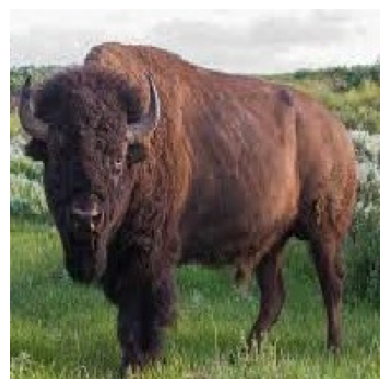

In [10]:
n = 19
plt.imshow(data[n]/255)
plt.axis('off');

In [11]:
x_train = preprocess_input(data)

ResNet 的預處理會將圖片的數據範圍常規化到 [-1, 1] 之間，與之前常規化到 [0, 1] 之間差一點點

畫圖時，matplotlib會自動作一些調整

每張圖的答案就是 0, 1, 2, 3, 4, 5, 6 其中一個數字。

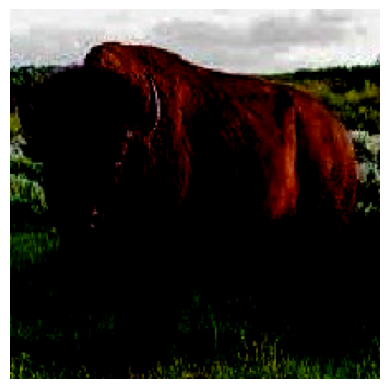

In [12]:
plt.imshow(x_train[n])
plt.axis('off');

看看這張圖是屬於哪個序號

In [13]:
target[n]

0

開始進行 One-Hot Encoding 程序

In [14]:
y_train = to_categorical(target, N)

圖片會對應到 N x 1 的矩陣中，數值在此，依據我們的分類，只有屬於其中一類，所以非 0 即 1

In [15]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0.])

## 數據轉換

將數據集從最原始的樣子，轉換成我們希望應用的演算法或模型，所需要的格式或形式

## 建立模型/應用演算法

In [16]:
# 建立模型
resnet = ResNet50V2(include_top=False, pooling="avg")

打造遷移學習版的函數學習機

In [17]:
model = Sequential()

In [18]:
model.add(resnet)

在預訓練模型外，再加上一層新的全連接層來進行分類，激發函數使用 softmax

In [19]:
model.add(Dense(N, activation='softmax'))

因為是遷移式學習，原本 ResNet 的部份不需要重新訓練。這邊設定不需要訓練。

In [20]:
resnet.trainable = False

Demostrate 我們的神經網路

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2048)                │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

組裝函數學習機

這裡用分類時非常標準的 categorical_crossentropy``，順便試試有名的adam` 學習法。

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## 6 效能評估

根據模型在數據集上的各種表現指標，來決定是否進行後續決策。

訓練 fit

In [23]:
# 訓練模型
model.fit(x_train, y_train, batch_size=20, epochs=10)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 554ms/step - accuracy: 0.3509 - loss: 1.7524
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9262 - loss: 0.5565
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9520 - loss: 0.2590
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9700 - loss: 0.1565
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9911 - loss: 0.1049
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9877 - loss: 0.0909
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9909 - loss: 0.0678
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9982 - loss: 0.0530
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9902 - loss: 0.0608
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0447


預測

用 model.evaluate 看一下模型表現

In [24]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 370ms/step - accuracy: 0.9881 - loss: 0.0444
Loss: 0.04072717949748039
Accuracy: 0.9941176176071167


In [25]:
y_pred = np.argmax(model.predict(x_train), -1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 725ms/step


In [26]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

比對正確答案

In [27]:
target

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6]

## 7 視覺化

視覺化是了解模型好壞最重要的工具

In [28]:
def resize_image(inp):
    # 將 NumPy array 轉換成 PIL Image 對象
    img = Image.fromarray(inp)

    # 將圖片調整為 224x224 像素
    img_resized = img.resize((224, 224), Image.Resampling.LANCZOS)

    # 將調整大小後的圖片轉換回 NumPy array
    img_array = np.array(img_resized)

    return img_array

In [29]:
def classify_image(inp):
    img_array = resize_image(inp)
    inp = img_array.reshape((1, 224, 224, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(N)}

In [30]:
# 準備範例圖片
sample_images = []
for i in range(N):
    thedir = os.path.join(base_dir, categories[i])
    for fname in os.listdir(thedir):
        sample_images.append(os.path.join(thedir, fname))

## 8 其他可行步驟 - 檢驗

根據數據來源的不同特性，我們可以對既有結果進行後許的檢查與評估

## 9 線上測試與部屬

``gradio`` 套件是你的線上部屬好朋友

In [31]:
# 建立並啟動介面
gr.Interface(
    fn=classify_image,
    inputs=gr.Image(label="牛牛照片"),
    outputs=gr.Label(num_top_classes=N, label="AI辨識結果"),
    title=title,
    description=description,
    examples=sample_images
).launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1a618b8b69228586c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1a618b8b69228586c2.gradio.live
